#### Google Drive 마운트


In [25]:
# Colab(구글 서버)에서 내 Google Drive(MyDrive)를 파일처럼 쓰기 위해 마운트
# 마운트가 되면 /content/drive/MyDrive/... 경로로 접근 가능

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 작업용 디렉토리 생성

In [3]:
# Colab 로컬(/content)에서 작업 결과를 쌓을 공간을 생성
# - /content/work/raw        : 중간 산출물/임시파일 저장용
# - /content/work/yolo_dataset: 최종 YOLO 형식 데이터셋 (images/labels/train/val) 저장용


!mkdir -p /content/work/raw
!mkdir -p /content/work/yolo_dataset

#### 라벨(JSON) 파일 경로 존재 확인

In [4]:
# Drive 경로 아래에 라벨(json 등)이 실제로 올라갔는지 빠르게 확인
# find로 파일 목록을 뽑고, head로 앞부분만 출력해서 "경로가 맞는지" 체크

!find "/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터" -type f | head -n 30

/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012335_S_Camera_203-001_7.json
/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012335_S_Camera_203-001_5.json
/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012335_S_Camera_203-001_9.json
/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012345_S_Camera_203-001_2.json
/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012345_S_Camera_203-001_3.json
/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012335_S_Camera_203-001_4.json
/content/drive/MyDrive/Colab Noteb

#### 라벨(JSON) 구조 1개 샘플 로드 & 최상위 키 확인

In [5]:
# 라벨 파일이 COCO 형식(annotations/images/categories)인지 확인하려면
# 우선 JSON 하나를 열어 "최상위가 dict인지", "키가 무엇인지"부터 봄

import glob, json  # glob: 파일 패턴 검색, json: JSON 로드/저장

# 라벨링 데이터가 있는 폴더 (Drive에 업로드한 Sample 기준)
LABEL_ROOT = "/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터"

# LABEL_ROOT 아래 모든 json 파일을 재귀적으로 찾음
paths = glob.glob(LABEL_ROOT + "/**/*.json", recursive=True)
print("json count:", len(paths))  # json이 0이면 경로가 틀렸거나 업로드가 안 된 상태

# 우선 첫 번째 json 파일을 샘플로 잡음
sample = paths[0]
print("sample json:", sample)

# JSON 로드(인코딩 utf-8로 시도)
with open(sample, "r", encoding="utf-8") as f:
    data = json.load(f)

print("top type:", type(data))  # 보통 COCO면 dict일 가능성이 큼
if isinstance(data, dict):
    # dict면 최상위 키를 출력. (예: annotations/images/categories)
    print("top keys:", list(data.keys())[:50])
else:
    # 리스트 구조인 데이터셋도 가끔 있으니 길이만 확인
    print("len:", len(data))

json count: 2501
sample json: /content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/02.라벨링데이터/정보저장매체/Camera/카메라(203)/E3S690_20220811_012335_S_Camera_203-001_7.json
top type: <class 'dict'>
top keys: ['images', 'annotations', 'categories', 'meta']


#### 라벨(JSON) 내부 구조 탐색 (annotations/images/categories 후보 키 확인)

In [6]:
# 정확히 어떤 key가 있고 안에 어떤 타입이 들어있는지" 탐색하는 용도

# - COCO는 보통 images(list), annotations(list), categories(list)
# - 이 셀은 후보 키가 있으면 그 안도 1~2단계 더 들어가 봄

# 흔한 후보 키들을 “있으면 출력"
candidates = [
    "annotations", "annotation",
    "objects", "object",
    "bbox", "bboxes",
    "labels",
    "images", "image",
    "categories", "category"
]

def peek(obj, depth=2, indent=0):
    # depth: 얼마나 깊게 들어가서 볼지
    if depth < 0:
        return

    prefix = " " * indent  # 들여쓰기

    if isinstance(obj, dict):
        # dict면 키와 값 타입을 먼저 나열
        for k in list(obj.keys())[:20]:
            v = obj[k]
            print(f"{prefix}- {k}: {type(v).__name__}")

        # 후보 키가 있으면 그 내부도 확인
        for k in candidates:
            if k in obj:
                print(f"\n{prefix}>> dive into '{k}'")
                peek(obj[k], depth-1, indent+2)

    elif isinstance(obj, list):
        # list면 길이와 첫 원소 타입을 확인
        print(f"{prefix}list(len={len(obj)})")
        if len(obj) > 0:
            print(f"{prefix}first item type: {type(obj[0]).__name__}")
            peek(obj[0], depth-1, indent+2)

# 로드한 data를 탐색
peek(data, depth=2)


- images: list
- annotations: list
- categories: list
- meta: list

>> dive into 'annotations'
  list(len=1)
  first item type: dict
    - id: int
    - image_id: int
    - iscrowd: int
    - category_id: int
    - bbox: list
    - area: float
    - segmentation: dict

    >> dive into 'bbox'

>> dive into 'images'
  list(len=1)
  first item type: dict
    - id: int
    - file_name: str
    - angle: int
    - height: int
    - width: int

>> dive into 'categories'
  list(len=1)
  first item type: dict
    - id: int
    - name: str
    - supercategory: NoneType


#### 경로 상수(PATH) 정리

In [7]:
# 앞으로 계속 사용할 경로를 변수로 정의

# - RAW_ROOT: Sample의 루트
# - IMG_ROOT: 01.원천데이터(이미지)
# - LBL_ROOT: 02.라벨링데이터(라벨 JSON)
# - WORK_ROOT: Colab 로컬 작업 폴더
# - YOLO_ROOT: YOLO 포맷 데이터셋 저장 폴더

RAW_ROOT = "/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample"
IMG_ROOT = RAW_ROOT + "/01.원천데이터"
LBL_ROOT = RAW_ROOT + "/02.라벨링데이터"

WORK_ROOT = "/content/work"
YOLO_ROOT = WORK_ROOT + "/yolo_dataset"

#### JSON 구조 확정(annotations/images/categories)

In [8]:
# COCO 포맷이면 아래가 대체로 성립
# - data["images"][0]      : 파일명(file_name), 이미지 크기(width/height)
# - data["categories"][0]  : 클래스 id/name
# - data["annotations"][0] : bbox, category_id 등이 존재

import glob, json

# 라벨 json을 하나 가져온다
p = glob.glob(LBL_ROOT + "/**/*.json", recursive=True)[0]
with open(p, "r", encoding="utf-8") as f:
    data = json.load(f)

# 첫 샘플들 뽑기
ann = data["annotations"][0]   # 첫 annotation
img = data["images"][0]        # 첫 image info
cat = data["categories"][0]    # 첫 category

# 핵심 필드 출력
print("file_name:", img["file_name"])
print("W,H:", img["width"], img["height"])
print("category:", cat["id"], cat["name"])

# COCO bbox는 보통 [x, y, w, h] (좌상단 x,y + 너비/높이)
print("bbox raw:", ann["bbox"], "len=", len(ann["bbox"]))

file_name: E3S690_20220811_012335_S_Camera_203-001_7.png
W,H: 896 760
category: 159 Camera
bbox raw: [610.0, 300.0, 62.0, 131.0] len= 4


#### YOLO 형식 데이터셋 디렉토리 초기화

In [9]:
# YOLOv5는 기본적으로 다음과 같은 구조
# YOLO_ROOT/
#   images/train, images/val
#   labels/train, labels/val
#
# 이 셀은 기존 결과물을 싹 지우고 다시 만들어서,
# 셀을 여러 번 실행해도 깨끗한 상태로 시작할 수 있도록 함

import os, shutil

# 기존 결과 삭제 후 재생성
shutil.rmtree(YOLO_ROOT, ignore_errors=True)                    # 폴더 통째로 삭제(없어도 에러 없음)
os.makedirs(f"{YOLO_ROOT}/images/train", exist_ok=True)         # train 이미지
os.makedirs(f"{YOLO_ROOT}/images/val", exist_ok=True)           # val 이미지
os.makedirs(f"{YOLO_ROOT}/labels/train", exist_ok=True)         # train 라벨(txt)
os.makedirs(f"{YOLO_ROOT}/labels/val", exist_ok=True)           # val 라벨(txt)

print("reset:", YOLO_ROOT)


reset: /content/work/yolo_dataset


#### 이미지 파일 인덱싱(Color/Gray, 파일명→경로)

In [10]:
# 모든 이미지를 glob로 찾고
# basename(파일명) -> fullpath(전체 경로) 매핑을 만들어
# JSON의 file_name으로 실제 이미지 파일을 빠르게 찾음

import glob, os

# Color/Gray 이미지 경로 전부 수집 (jpg + png)
img_paths_color = (
    glob.glob(IMG_ROOT + "/Color/**/*.jpg", recursive=True) +
    glob.glob(IMG_ROOT + "/Color/**/*.png", recursive=True)
)
img_paths_gray  = (
    glob.glob(IMG_ROOT + "/Gray/**/*.jpg",  recursive=True) +
    glob.glob(IMG_ROOT + "/Gray/**/*.png",  recursive=True)
)

print("images found (Color):", len(img_paths_color))
print("images found (Gray) :", len(img_paths_gray))

# 인덱스(딕셔너리): "파일명" -> "전체경로"
img_index_color = {}
img_index_gray  = {}

# 같은 파일명이 여러 폴더에 중복될 수도 있으므로, 중복은 카운트만 올리고 첫 번째만 사용
dup_color = 0
for fp in img_paths_color:
    bn = os.path.basename(fp)              # 파일명만 추출
    if bn in img_index_color:              # 이미 같은 파일명이 있다면
        dup_color += 1                     # 중복 카운트
    else:
        img_index_color[bn] = fp           # 최초 등록

dup_gray = 0
for fp in img_paths_gray:
    bn = os.path.basename(fp)
    if bn in img_index_gray:
        dup_gray += 1
    else:
        img_index_gray[bn] = fp

print("indexed (Color):", len(img_index_color), "dup skipped:", dup_color)
print("indexed (Gray) :", len(img_index_gray),  "dup skipped:", dup_gray)

images found (Color): 2501
images found (Gray) : 2501
indexed (Color): 2501 dup skipped: 0
indexed (Gray) : 2501 dup skipped: 0


#### 전체 클래스 목록 수집 & name→index 매핑 생성

In [18]:
# YOLO 라벨(txt)은 클래스가 "0 ~ (nc-1)" 정수 인덱스로 고정됨
# 그런데 COCO JSON은 category_id가 1, 3, 7 처럼 불연속일 수 있음
#
# 따라서
# 1) 모든 JSON에서 categories.name을 모아서
# 2) 정렬(sorted) 후
# 3) name_to_idx 로 (클래스명 -> 0..N-1)

import glob, json

# 전체 라벨 json 목록
json_paths = glob.glob(LBL_ROOT + "/**/*.json", recursive=True)
print("json files:", len(json_paths))

class_names = set()  # 중복 제거를 위해 set 사용
for p in json_paths:
    with open(p, "r", encoding="utf-8") as f:
        d = json.load(f)
    for c in d.get("categories", []):          # categories 없을 수도 있으니 get 사용
        class_names.add(c["name"])             # 클래스 이름 모으기

class_names = sorted(class_names)              # 정렬 (고정된 순서를 만들기 위해 중요!)
print("classes found:", len(class_names))
print(class_names[:30])                        # 너무 길면 앞쪽만 확인

# name -> class_id(0..)
name_to_idx = {n: i for i, n in enumerate(class_names)}

json files: 2501
processed 100/2501
processed 200/2501
processed 300/2501
processed 400/2501
processed 500/2501
processed 600/2501
processed 700/2501
processed 800/2501
processed 900/2501
processed 1000/2501
processed 1100/2501
processed 1200/2501
processed 1300/2501
processed 1400/2501
processed 1500/2501
processed 1600/2501
processed 1700/2501
processed 1800/2501
processed 1900/2501
processed 2000/2501
processed 2100/2501
processed 2200/2501
processed 2300/2501
processed 2400/2501
processed 2500/2501
classes found: 48
['Awl', 'Ax', 'Baton-folding', 'Bullet', 'Butterfly knife', 'Camera', 'Chisel', 'Crowbar', 'Driver', 'Dumbbel', 'Electroshock weapon', 'Firecracker', 'Folder phone', 'Grenade', 'Hex key(over 10cm)', 'Hoe', 'Homi', 'Knife blade', 'Knife-A', 'Knife-C', 'Knife-D', 'Knife-E', 'Knife-F', 'LAGs products(Aluminum-C)', 'LAGs products(Glass-C)', 'LAGs products(Glass-D)', 'LAGs products(Plastic-B)', 'LAGs products(Plastic-C)', 'LAGs products(Plastic-D)', 'LAGs products(Tube-C)']


#### COCO bbox → YOLO bbox 변환 함수 + (Color/Gray 동시 처리)

In [19]:
# COCO bbox: (x, y, w, h)
# - (x, y) = 좌상단 픽셀 좌표
# - (w, h) = 너비/높이 (픽셀)
#
# YOLO bbox: (class_idx, x_center, y_center, w, h)
# - x_center, y_center, w, h 가 모두 0~1 범위로 "정규화(normalized)" 되어야 함
# - 즉, x_center = (x + w/2) / img_w 같은 형태가 됨

import os, json

def coco_bbox_to_yolo(bbox, img_w, img_h):
    """
    COCO bbox(x,y,w,h)를 YOLO bbox(x_center, y_center, w, h)로 변환
    단, YOLO는 0~1 범위여야 하므로 img_w/img_h로 나눠 정규화
    """
    x, y, w, h = bbox                 # COCO: 좌상단(x,y) + 너비/높이(w,h)
    xc = x + w / 2.0                  # 중심 x (픽셀)
    yc = y + h / 2.0                  # 중심 y (픽셀)

    # YOLO는 0~1 정규화
    return (xc / img_w, yc / img_h, w / img_w, h / img_h)

def write_yolo_label_txt(d, img_w, img_h, dst_lbl_path):
    """
    라벨 JSON(d)의 annotations를 읽어서,
    YOLO 라벨 txt 파일(dst_lbl_path)을 생성

    txt 1줄 형식:
      class_idx x_center y_center w h
    """
    # COCO categories에서 (원본 category_id -> name) 매핑을 만듦
    # (예: 17 -> "Knife-A") 같은 식으로 들어있을 수 있음
    id_to_name = {c["id"]: c["name"] for c in d.get("categories", [])}

    label_lines = []  # txt에 쓸 한 줄씩 누적

    for ann in d.get("annotations", []):
        cid = ann["category_id"]                  # COCO category id

        # cid가 categories에 없는 이상한 케이스는 건너뜀
        if cid not in id_to_name:
            continue

        cls_name = id_to_name[cid]                # 클래스명
        cls_idx = name_to_idx[cls_name]           # 0..N-1 인덱스로 변환

        # bbox 변환 (COCO -> YOLO normalized)
        x, y, w, h = coco_bbox_to_yolo(ann["bbox"], img_w, img_h)

        # (라벨 오류/반올림) 0~1로 clamp
        x = min(max(x, 0.0), 1.0)
        y = min(max(y, 0.0), 1.0)
        w = min(max(w, 0.0), 1.0)
        h = min(max(h, 0.0), 1.0)

        # YOLO txt 라인 생성 (소수점 6자리로 고정)
        label_lines.append(f"{cls_idx} {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

    # 라벨 파일 저장
    with open(dst_lbl_path, "w", encoding="utf-8") as f:
        f.write("\n".join(label_lines))

def safe_symlink(src, dst):
    """
    Colab에서 copy로 복사하면 시간이 오래 걸릴 수 있어 symlink(바로가기 링크)를 사용
    - dst가 이미 있으면 지우고 다시 만들기 때문에 "재실행"해도 안전함
    """
    # 이미 파일/링크가 있으면 삭제
    if os.path.islink(dst) or os.path.exists(dst):
        os.remove(dst)

    # symlink 생성 (dst가 src를 가리키게 됨)
    os.symlink(src, dst)

def process_one_both(image_filename, json_path, split_name):
    """
    라벨(JSON) 1개로 Color/Gray 이미지 둘 다 YOLO 데이터로 만듦

    결과:
    - images/{split}/Color_<파일명> (symlink)
    - images/{split}/Gray_<파일명>  (symlink)
    - labels/{split}/Color_<파일명>.txt
    - labels/{split}/Gray_<파일명>.txt

    split_name: "train" or "val"
    """
    # 라벨 JSON 로드
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)

    # 이 JSON이 어떤 이미지에 대한 라벨인지 확인
    img_info = d["images"][0]              # COCO는 images가 list이고 보통 1개만 들어있다고 가정
    img_w, img_h = img_info["width"], img_info["height"]

    # JSON의 file_name과 실제 폴더에서 찾을 파일명(기본명)
    bn = os.path.basename(image_filename)  # file_name에 경로가 있어도 마지막 파일명만 사용

    # Color/Gray 각각 실제 이미지 경로를 인덱스에서 찾기
    src_color = img_index_color.get(bn)
    src_gray  = img_index_gray.get(bn)

    # 둘 다 없으면 라벨은 있는데 이미지 파일이 없는 상태 → 에러로 처리
    if (src_color is None) and (src_gray is None):
        raise FileNotFoundError(f"Both Color/Gray images not found for: {bn} (label={json_path})")

    # -------------------------
    # 1) Color 이미지 처리
    # -------------------------
    if src_color is not None:
        new_bn = f"Color_{bn}"                                 # 파일명에 Color_ prefix 붙여 구분
        dst_img = f"{YOLO_ROOT}/images/{split_name}/{new_bn}"  # YOLO dataset 위치
        safe_symlink(src_color, dst_img)                       # 원본을 복사하지 않고 링크로 연결

        # 라벨 txt 파일명은 이미지 파일명(확장자 제외)와 동일해야 YOLO가 매칭합니다.
        dst_lbl = f"{YOLO_ROOT}/labels/{split_name}/{os.path.splitext(new_bn)[0]}.txt"
        write_yolo_label_txt(d, img_w, img_h, dst_lbl)          # COCO -> YOLO txt 변환 저장

    # -------------------------
    # 2) Gray 이미지 처리
    # -------------------------
    if src_gray is not None:
        new_bn = f"Gray_{bn}"
        dst_img = f"{YOLO_ROOT}/images/{split_name}/{new_bn}"
        safe_symlink(src_gray, dst_img)

        dst_lbl = f"{YOLO_ROOT}/labels/{split_name}/{os.path.splitext(new_bn)[0]}.txt"
        write_yolo_label_txt(d, img_w, img_h, dst_lbl)

#### Train/Val 8:2 분리 후 YOLO 데이터셋 생성

In [20]:
# 전체 라벨 JSON을 돌면서
# 1) (file_name, json_path) 목록을 만든 다음
# 2) file_name 기준으로 중복이 있으면 마지막 것을 채택(uniq 딕셔너리)
# 3) 랜덤 셔플 후 80% train, 20% val 분리
# 4) 각 split마다 process_one_both를 호출하여
#    Color/Gray 이미지 + 라벨 txt를 생성

import random, json

random.seed(42)  # 항상 같은 랜덤 분할이 나오도록 고정(재현성)

items = []  # (file_name, json_path)
for p in json_paths:                               # 셀10에서 만든 전체 json_paths 사용
    with open(p, "r", encoding="utf-8") as f:
        d = json.load(f)

    fn = d["images"][0]["file_name"]               # 라벨이 가리키는 이미지 파일명
    items.append((fn, p))

# 같은 file_name이 여러 json에서 반복될 수도 있으니 대비
# (샘플은 보통 1:1이지만, 안전하게 처리)
uniq = {}
for fn, p in items:
    uniq[fn] = p                                   # 같은 fn이 오면 덮어씀(마지막 것이 남음)

items = list(uniq.items())                         # (fn, json_path)
print("unique label items:", len(items))

random.shuffle(items)                              # 셔플
split = int(len(items) * 0.8)                      # 80% 지점
train_items = items[:split]
val_items = items[split:]
print("train:", len(train_items), "val:", len(val_items))

errors = 0  # 에러 카운터

# train 변환
for fn, jp in train_items:
    try:
        process_one_both(fn, jp, "train")          # Color/Gray 동시에 생성
    except Exception as e:
        errors += 1                                # 에러만 카운트(필요하면 print(e)로 로그 출력 가능)

# val 변환
for fn, jp in val_items:
    try:
        process_one_both(fn, jp, "val")
    except Exception as e:
        errors += 1

print("done. errors:", errors)                      # errors가 0이면 이상적

unique label items: 2501
train: 2000 val: 501
[train] 100/2000 done, errors=0
[train] 200/2000 done, errors=0
[train] 300/2000 done, errors=0
[train] 400/2000 done, errors=0
[train] 500/2000 done, errors=0
[train] 600/2000 done, errors=0
[train] 700/2000 done, errors=0
[train] 800/2000 done, errors=0
[train] 900/2000 done, errors=0
[train] 1000/2000 done, errors=0
[train] 1100/2000 done, errors=0
[train] 1200/2000 done, errors=0
[train] 1300/2000 done, errors=0
[train] 1400/2000 done, errors=0
[train] 1500/2000 done, errors=0
[train] 1600/2000 done, errors=0
[train] 1700/2000 done, errors=0
[train] 1800/2000 done, errors=0
[train] 1900/2000 done, errors=0
[train] 2000/2000 done, errors=0
[val] 100/501 done, errors=0
[val] 200/501 done, errors=0
[val] 300/501 done, errors=0
[val] 400/501 done, errors=0
[val] 500/501 done, errors=0
done. errors: 0


#### YOLOv5용 data.yaml 생성

In [21]:
# YOLOv5 학습(train.py)은 data.yaml을 통해 데이터셋 위치/클래스 정보를 읽음
# - path: 데이터셋 루트
# - train/val: path 기준 상대 경로
# - nc: 클래스 수
# - names: 클래스명 리스트

yaml_path = YOLO_ROOT + "/data.yaml"
with open(yaml_path, "w", encoding="utf-8") as f:
    f.write(f"path: {YOLO_ROOT}\n")                # 데이터셋 루트 경로
    f.write("train: images/train\n")               # train 이미지 폴더(상대경로)
    f.write("val: images/val\n\n")                 # val 이미지 폴더(상대경로)
    f.write(f"nc: {len(class_names)}\n")           # 클래스 개수
    f.write("names: [")
    f.write(", ".join([f"'{n}'" for n in class_names]))  # 클래스명 배열
    f.write("]\n")

print("written:", yaml_path)

written: /content/work/yolo_dataset/data.yaml


#### 생성 결과(이미지/라벨 개수) 검증

In [22]:
# YOLO 형식에서는
# - images/train의 각 이미지에 대해 labels/train에 같은 이름의 .txt가 있어야 함
# - 개수가 많이 다르면 변환/매칭이 깨진 것

import glob

train_imgs = glob.glob(YOLO_ROOT + "/images/train/*")
train_lbls = glob.glob(YOLO_ROOT + "/labels/train/*")
val_imgs   = glob.glob(YOLO_ROOT + "/images/val/*")
val_lbls   = glob.glob(YOLO_ROOT + "/labels/val/*")

print("train images:", len(train_imgs), "train labels:", len(train_lbls))
print("val images:", len(val_imgs), "val labels:", len(val_lbls))

print("sample train img:", train_imgs[0] if train_imgs else None)
print("sample train lbl:", train_lbls[0] if train_lbls else None)

train images: 4000 train labels: 4000
val images: 1002 val labels: 1002
sample train img: /content/work/yolo_dataset/images/train/Gray_E3S690_20220811_012413_P_Chisel_060-001_Chisel_060-002_4.png
sample train lbl: /content/work/yolo_dataset/labels/train/Color_E3S690_20220811_012480_M_Rifle_004-001_Knife-A_020-001_1.txt


#### 샘플 1장 시각화(박스 overlay)로 라벨 검증

image: /content/work/yolo_dataset/images/train/Color_E3S690_20220811_012274_S_Scissors-A_037-001_4.png
label: /content/work/yolo_dataset/labels/train/Color_E3S690_20220811_012274_S_Scissors-A_037-001_4.txt
num boxes: 1


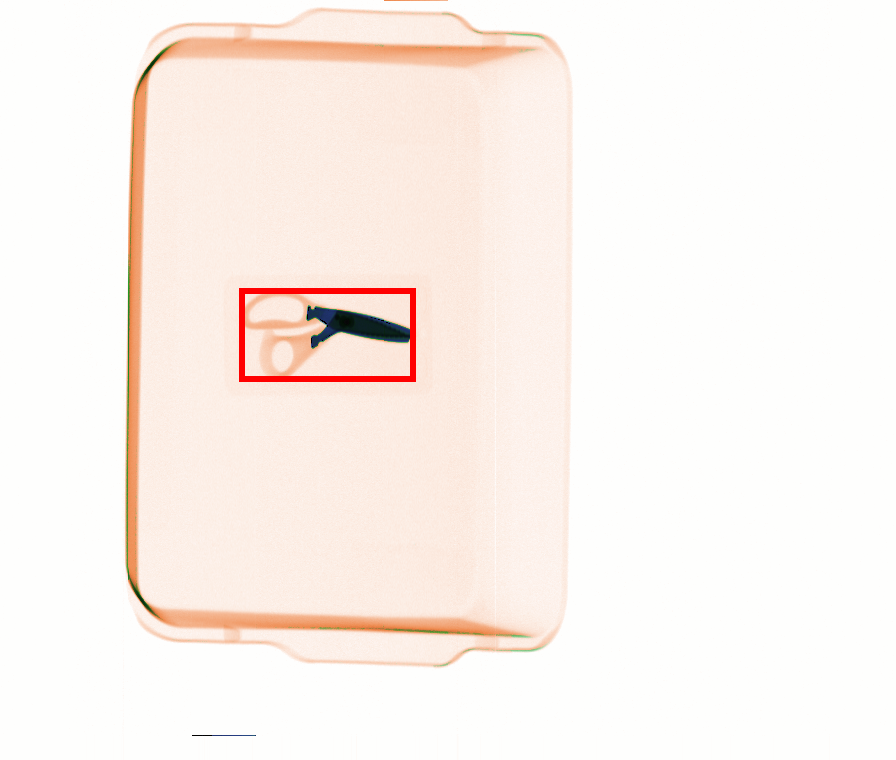

In [23]:
# 라벨이 제대로 변환되었는지 눈으로 확인하는 단계
#
# - 박스가 물체 위에 제대로 올라가야 정상
# - 박스가 화면 밖으로 튀거나 너무 이상하면:
#   (1) bbox 변환식이 틀렸거나 (COCO -> YOLO)
#   (2) img_w/img_h가 실제 이미지 크기와 다르거나
#   (3) 라벨 JSON이 COCO가 아니거나
#
# 또한 Gray 이미지가 16-bit/float일 수 있어서
# 그냥 PIL로 열면 "하얗게 보이거나" 이상하게 보일 수 있음
# 그래서 Gray는 안전하게 0~255로 정규화해서 보여주는 함수로 변경함

import random, os
import numpy as np
from PIL import Image, ImageDraw, ImageOps

# 샘플 1장 뽑기 (train에서)
img_path = random.choice(train_imgs)  # images/train 중 랜덤 1장
lbl_path = os.path.join(
    YOLO_ROOT, "labels/train",
    os.path.splitext(os.path.basename(img_path))[0] + ".txt"  # 이미지 파일명과 동일한 txt
)

def load_image_safe_for_view(path: str) -> Image.Image:
    """
    - Color: 그냥 RGB로 변환해서 보기
    - Gray: 16-bit/float/팔레트/알파 등을 안전하게 8-bit로 정규화해서 보기
    """
    # 파일명에 Gray_가 붙었으면 Gray 데이터라고 판단
    is_gray = ("Gray_" in os.path.basename(path)) or ("/Gray/" in path.replace("\\", "/"))

    im = Image.open(path)  # PIL로 이미지 열기

    if not is_gray:
        # Color는 일반적으로 RGB로 보여주면 됩니다.
        return im.convert("RGB")

    # --- Gray 처리 ---
    # 1) 알파 채널이 섞여있을 수 있으므로 흰 배경과 합성
    if im.mode in ("RGBA", "LA"):
        bg = Image.new("RGBA", im.size, (255, 255, 255, 255))
        im = Image.alpha_composite(bg, im.convert("RGBA")).convert("RGB")
        im = im.convert("L")  # 다시 흑백
    else:
        # 16bit/float 같은 모드는 I나 F로 올 수 있어서 안전하게 처리
        im = im.convert("I") if im.mode in ("I;16", "I", "F") else im.convert("L")

    # 2) numpy로 읽어서 float로 만들고 범위를 확인
    a = np.array(im).astype(np.float32)
    mn, mx = float(a.min()), float(a.max())

    # 값이 거의 일정하면(진짜 빈 프레임) 그냥 검정으로 표시
    if mx <= mn + 1e-6:
        out = np.zeros_like(a, dtype=np.uint8)
        return Image.fromarray(out, mode="L").convert("RGB")

    # 3) 퍼센타일 기반 정규화(1~99%)로 극단치(outlier) 영향 줄이기
    lo = np.percentile(a, 1)
    hi = np.percentile(a, 99)
    if hi <= lo + 1e-6:
        lo, hi = mn, mx

    a = (a - lo) / (hi - lo)          # 0~1로 스케일
    a = np.clip(a, 0, 1) * 255.0      # 0~255로 변환
    out = a.astype(np.uint8)

    return Image.fromarray(out, mode="L").convert("RGB")

# 이미지 로드 (Gray면 안전 정규화)
img = load_image_safe_for_view(img_path)
W, H = img.size                     # 이미지 크기(픽셀)
draw = ImageDraw.Draw(img)          # 그리기 객체

# 라벨 txt 읽기 (빈 줄 제거)
with open(lbl_path, "r", encoding="utf-8") as f:
    lines = [ln.strip() for ln in f.readlines() if ln.strip()]

print("image:", img_path)
print("label:", lbl_path)
print("num boxes:", len(lines))

# 각 라벨 라인을 박스로 변환해서 그림
for ln in lines:
    cls, xc, yc, w, h = ln.split()                  # YOLO 라벨: class, x_center, y_center, w, h
    xc, yc, w, h = map(float, (xc, yc, w, h))       # 문자열 -> float

    # YOLO(정규화) -> 픽셀 좌표로 변환
    x1 = (xc - w/2) * W
    y1 = (yc - h/2) * H
    x2 = (xc + w/2) * W
    y2 = (yc + h/2) * H

    # 안전 클립(이미지 밖으로 나가면 잘라내기)
    x1 = max(0, min(W-1, x1)); x2 = max(0, min(W-1, x2))
    y1 = max(0, min(H-1, y1)); y2 = max(0, min(H-1, y2))

    # 박스 그리기 (빨간색)
    draw.rectangle([x1, y1, x2, y2], outline="red", width=6)

# Image 객체 출력
img

#### 심볼릭 링크/파일 크기 확인(데이터 연결 확인)

In [24]:
# copy 대신 symlink 썼기 때문에
#
# - exists: 파일이 존재하나?
# - islink: 이 파일이 실제 파일이 아니라 "링크"인가?
# - readlink: 어떤 원본 파일을 가리키는가?

import os

print("exists:", os.path.exists(img_path))      # 파일이 있나?
print("islink:", os.path.islink(img_path))      # 심볼릭 링크인가?

if os.path.islink(img_path):
    print("link ->", os.readlink(img_path))     # 링크가 가리키는 실제 원본 경로

# 파일 크기 체크 (0이거나 너무 작으면 이상)
print("size(bytes):", os.path.getsize(img_path))

exists: True
islink: True
link -> /content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/Sample/01.원천데이터/Color/위해물품/Scissors-A/문구용 가위(접은 형태)(037)/E3S690_20220811_012274_S_Scissors-A_037-001_4.png
size(bytes): 514964


#### YOLOv5 레포 설치

In [25]:
# Ultralytics YOLOv5 레포를 Colab 로컬(/content)에 받음
# - 이미 있다면 rm -rf로 삭제 후 다시 받기(깨끗한 상태 유지)
# - requirements.txt 설치는 첫 1회만 해도 되지만, 다시 설치해도 됨

%cd /content
!rm -rf yolov5
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17778, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 17778 (delta 98), reused 51 (delta 51), pack-reused 17623 (from 3)
Receiving objects: 100% (17778/17778), 17.14 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (12077/12077), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 73.5 MB/s eta 0:00:00


#### GPU/CUDA 환경 확인

In [26]:
# - cuda available: True면 GPU 사용 가능
# - gpu: 모델명 출력

import torch

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

torch: 2.9.0+cu126
cuda available: True
gpu: Tesla T4


#### YOLOv5 학습 실행(train.py)

In [28]:
# YOLOv5 학습 실행
#
# --img 640    : 입력 이미지 크기(학습 시 리사이즈)
# --batch 16   : 배치 크기(메모리 부족하면 8, 4로 낮추기)
# --epochs 20  : 에폭 수(학습 반복 횟수)
# --data ...   : 우리가 만든 data.yaml 경로
# --weights ...: 사전학습 가중치로 시작(처음부터 학습보다 성능/수렴이 빠름)
# --name ...   : runs/train/<name> 폴더로 결과 저장
# --cache      : 데이터 로딩 가속(메모리 부족하면 빼도 됨)

%cd /content/yolov5

DATA_YAML = "/content/work/yolo_dataset/data.yaml"

!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 20 \
  --data {DATA_YAML} \
  --weights yolov5s.pt \
  --name aihub_sample_color_gray_baseline \
  --cache

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  with torch.cuda.amp.autocast(amp):
      10/19      4.31G    0.04936    0.01145    0.02922         40        640:  22% 54/250 [00:15<00:57,  3.42it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      10/19      4.31G    0.04937    0.01145    0.02934         54        640:  22% 55/250 [00:15<00:59,  3.29it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      10/19      4.31G     0.0493    0.01142    0.02933         42        640:  22% 56/250 [00:16<01:04,  3.03it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      10/19 

#### 학습 결과(run 폴더) 파일 존재 확인

In [29]:
# 학습이 성공하면 runs/train/<name>/ 아래에
# - weights/best.pt, last.pt
# - results.png, confusion_matrix.png 등
# 이 생성됨

import os, glob

RUN_DIR = "/content/yolov5/runs/train/aihub_sample_color_gray_baseline"
print("exists:", os.path.exists(RUN_DIR))

print("\n[weights]")
print(glob.glob(RUN_DIR + "/weights/*"))  # best.pt, last.pt가 보여야 정상

print("\n[plots]")
print(glob.glob(RUN_DIR + "/*.png"))      # results.png 등이 보이면 정상

exists: True

[weights]
['/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/last.pt', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/best.pt']

[plots]
['/content/yolov5/runs/train/aihub_sample_color_gray_baseline/PR_curve.png', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/R_curve.png', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/F1_curve.png', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/P_curve.png', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/results.png', '/content/yolov5/runs/train/aihub_sample_color_gray_baseline/confusion_matrix.png']


#### 학습 결과 그래프(results.png) 표시

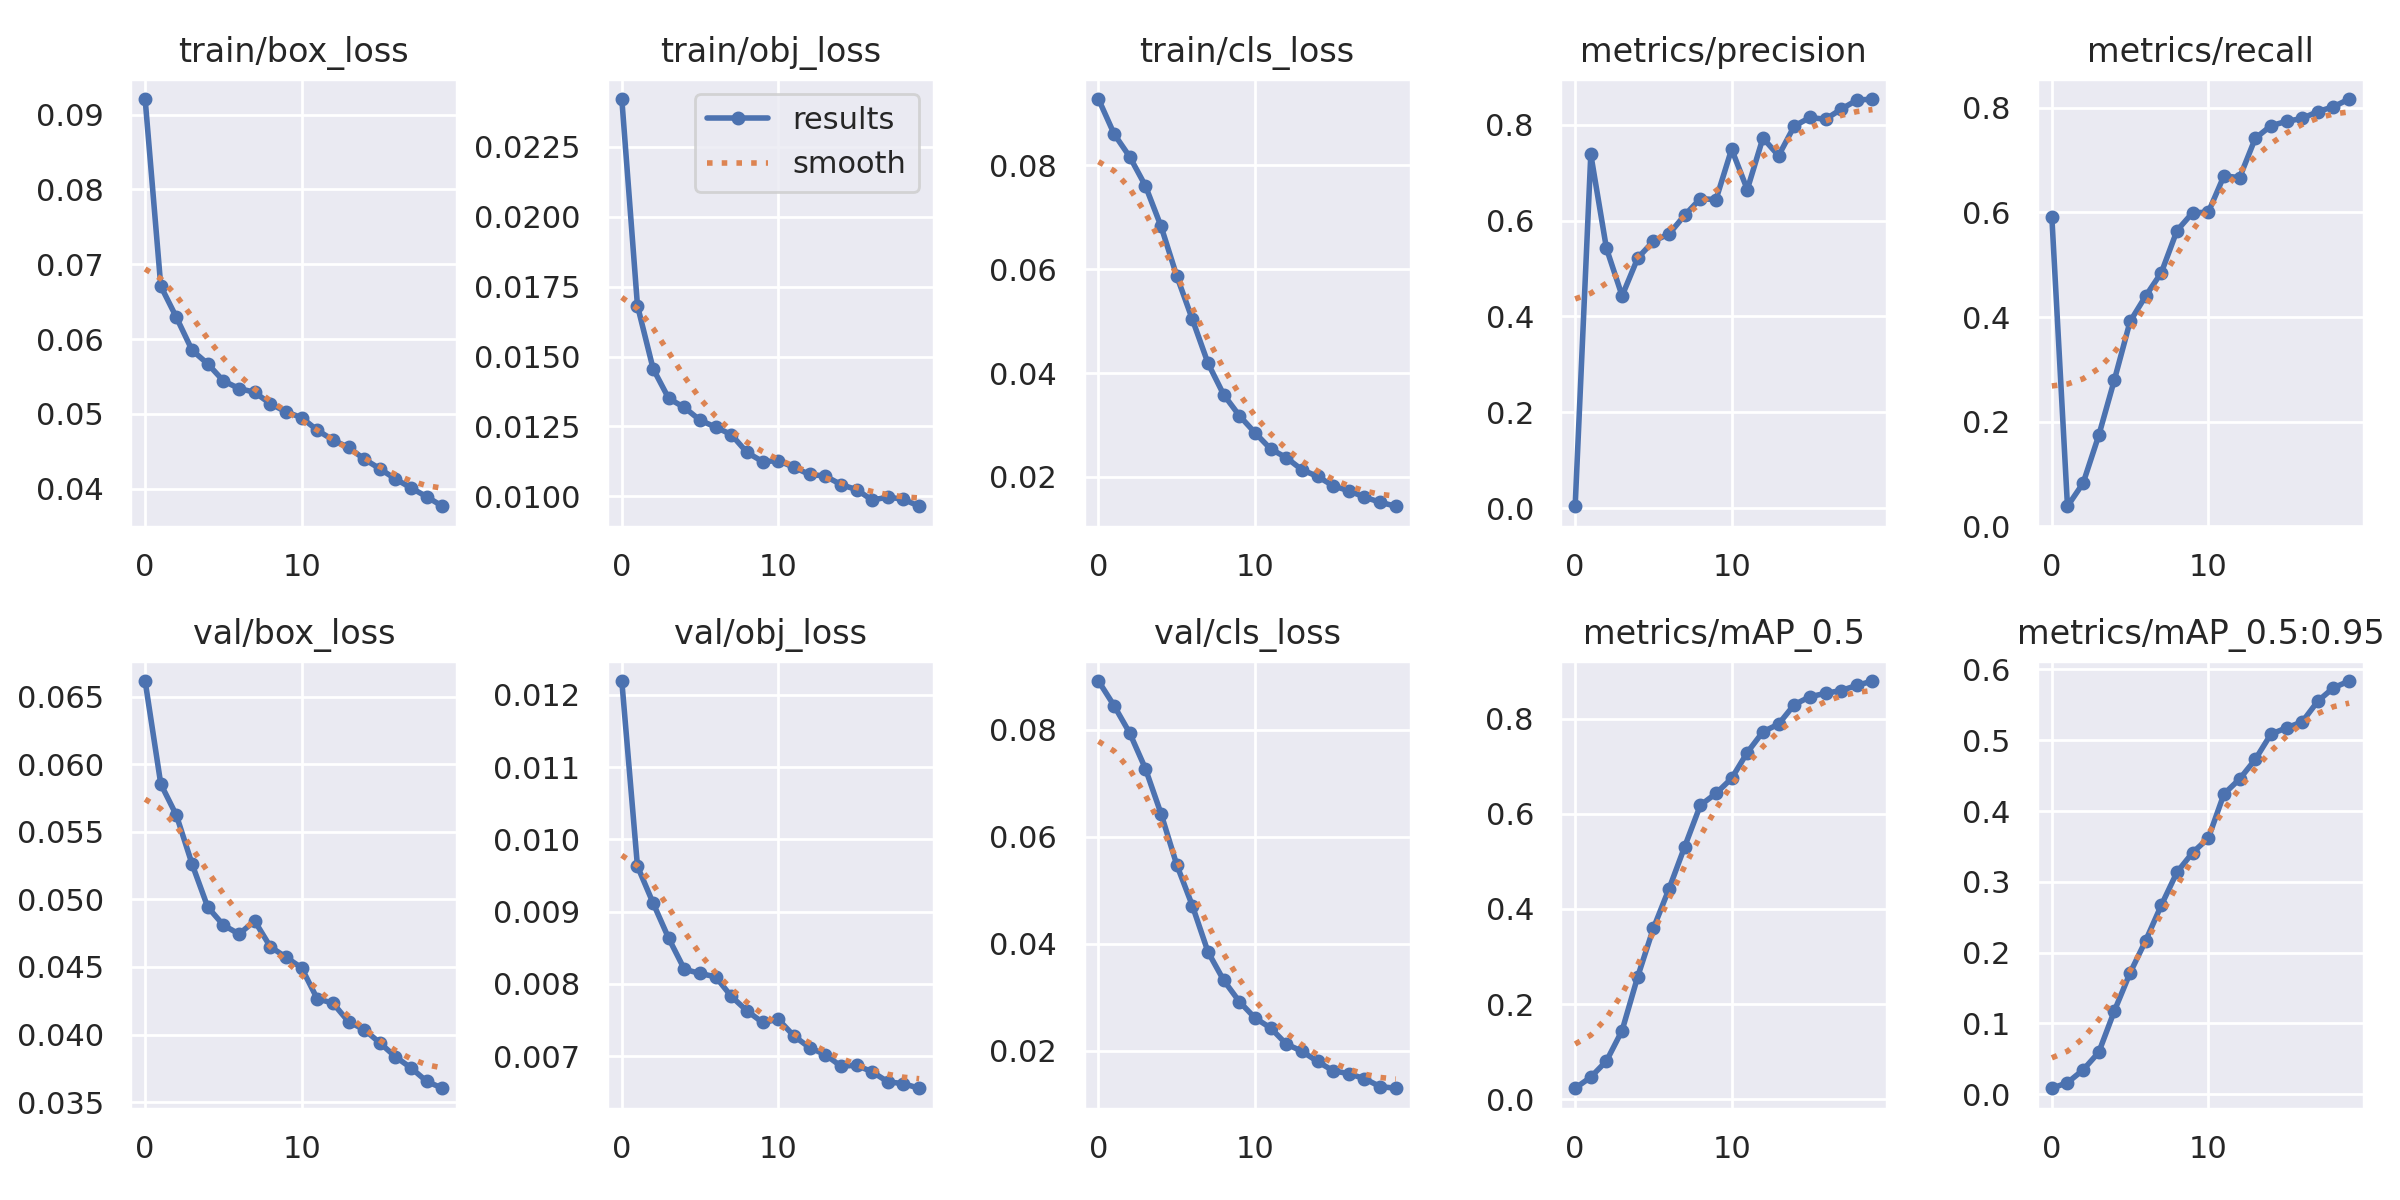

In [30]:
# results.png에는 loss/precision/recall/mAP 등 학습 곡선이 요약
# 파일이 없으면 학습이 중간에 실패했거나, name 경로가 다를 수 있음

from PIL import Image
from pathlib import Path

img_path = Path("/content/yolov5/runs/train/aihub_sample_color_gray_baseline/results.png")
if img_path.exists():
    display(Image.open(img_path))
else:
    print("results.png not found:", img_path)

#### best.pt로 검증(val.py)

In [31]:
# best.pt를 사용해 validation 성능을 측정
# - mAP, precision, recall 등이 출력됨

%cd /content/yolov5

BEST = "/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/best.pt"

!python val.py \
  --weights {BEST} \
  --data /content/work/yolo_dataset/data.yaml \
  --img 640

/content/yolov5
val: data=/content/work/yolo_dataset/data.yaml, weights=['/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7139581 parameters, 0 gradients, 16.2 GFLOPs
val: Scanning /content/work/yolo_dataset/labels/val.cache... 1002 images, 0 backgrounds, 0 corrupt: 100% 1002/1002 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 32/32 [00:37<00:00,  1.17s/it]
                   all       1002       1740      0.853      0.817      0.879      0.584
                   Awl       1002  

#### best.pt로 추론(detect.py)

In [32]:
# val 이미지 폴더를 대상으로 추론해서 박스가 그려진 결과 이미지를 생성
# --conf 0.25 : confidence threshold (낮추면 박스가 더 많이 뜰 수 있음)
# --name ...  : runs/detect/<name> 폴더로 저장

%cd /content/yolov5

BEST = "/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/best.pt"

!python detect.py \
  --weights {BEST} \
  --source /content/work/yolo_dataset/images/val \
  --img 640 \
  --conf 0.25 \
  --name aihub_sample_pred

/content/yolov5
detect: weights=['/content/yolov5/runs/train/aihub_sample_color_gray_baseline/weights/best.pt'], source=/content/work/yolo_dataset/images/val, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=aihub_sample_pred, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-453-geed9bc19 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7139581 parameters, 0 gradients, 16.2 GFLOPs
image 1/1002 /content/work/yolo_dataset/images/val/Color_E3S690_20220810_012121_S_Rifle_004-001_2.png: 544x640 1 Rifle, 34.6ms
image 2/1002 /content/work/yolo_dataset/images/val/Color_E3S690_20220810_012121_S_Rifle_004-00

#### 추론 결과 이미지 샘플 확인

pred images: 1002


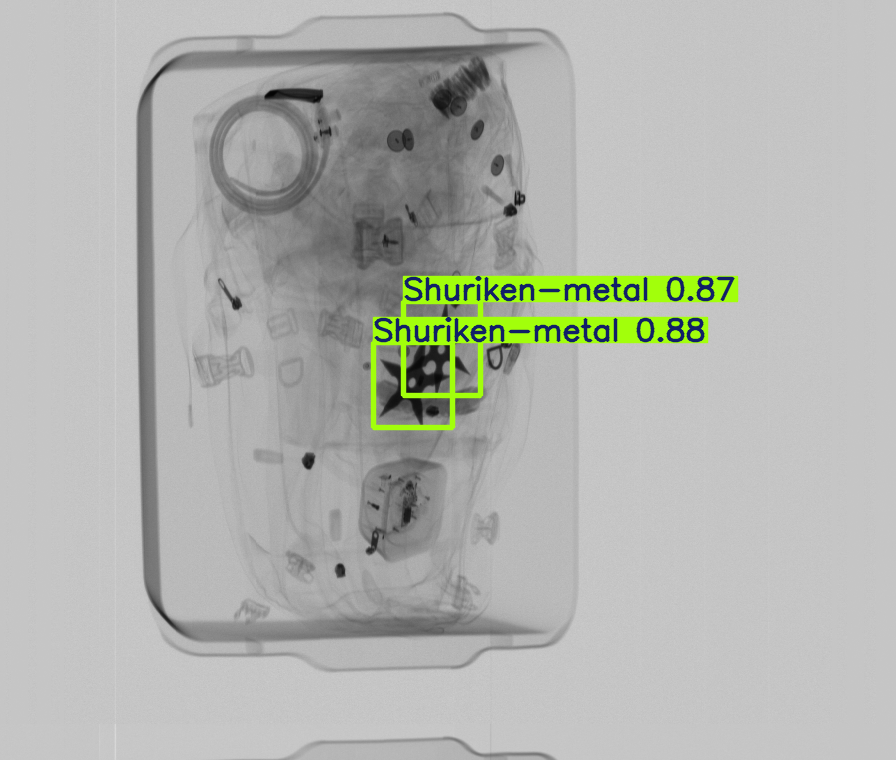

/content/yolov5/runs/detect/aihub_sample_pred/Gray_E3S690_20220811_012365_P_Shuriken-metal_010-001_Shuriken-metal_010-002_9.png


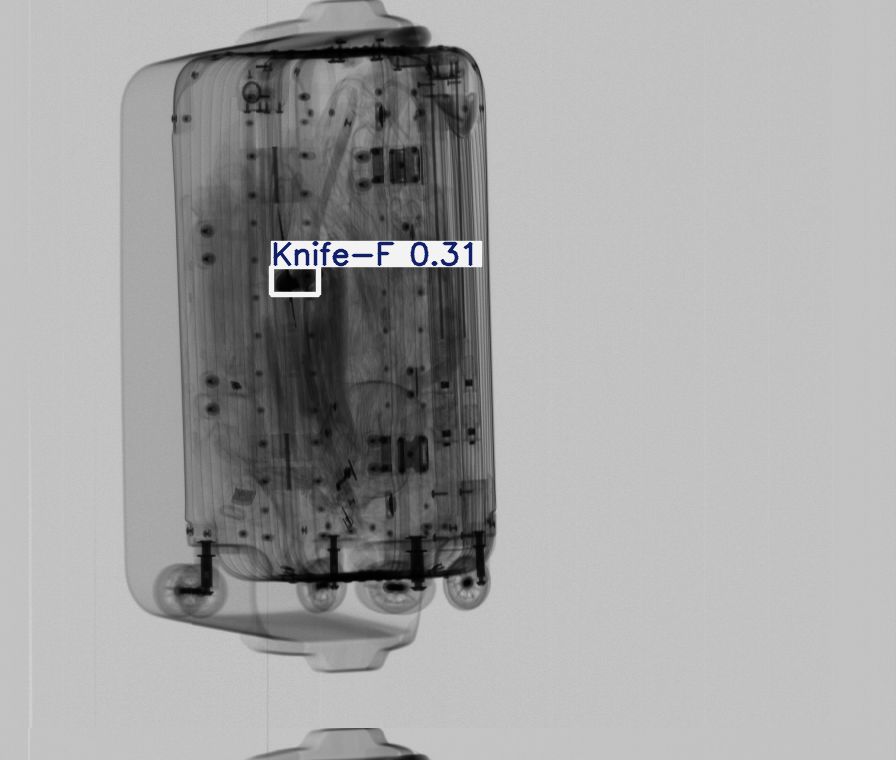

/content/yolov5/runs/detect/aihub_sample_pred/Gray_E3S690_20220811_012371_P_Knife-F_018-001_Knife-F_018-002_6.png


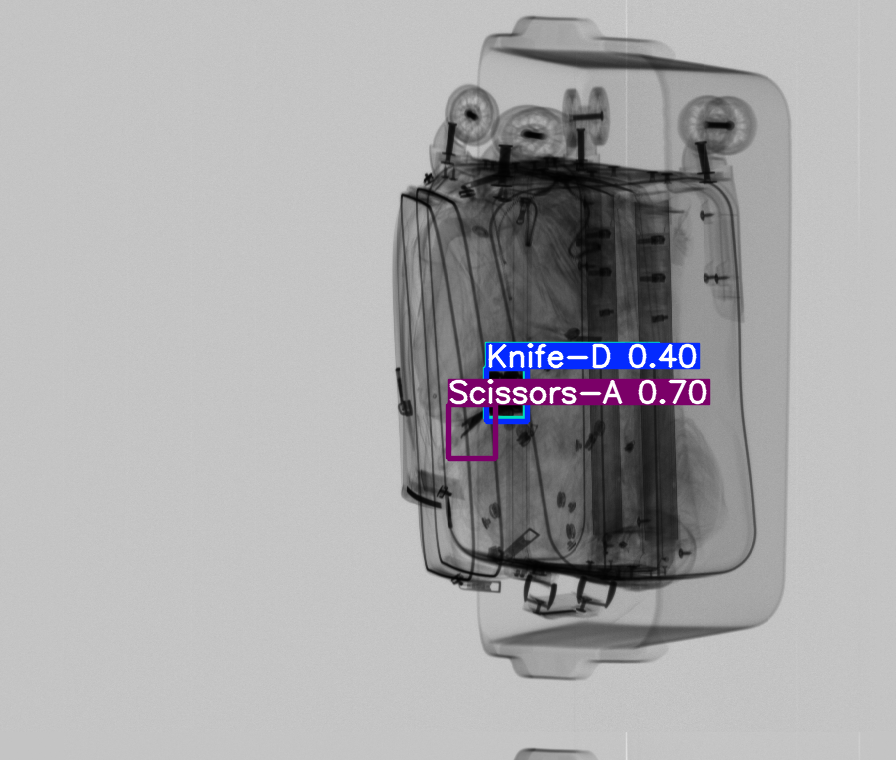

/content/yolov5/runs/detect/aihub_sample_pred/Gray_E3S690_20220816_012966_M_Scissors-A_037-003_Knife-D_029-003_7.png


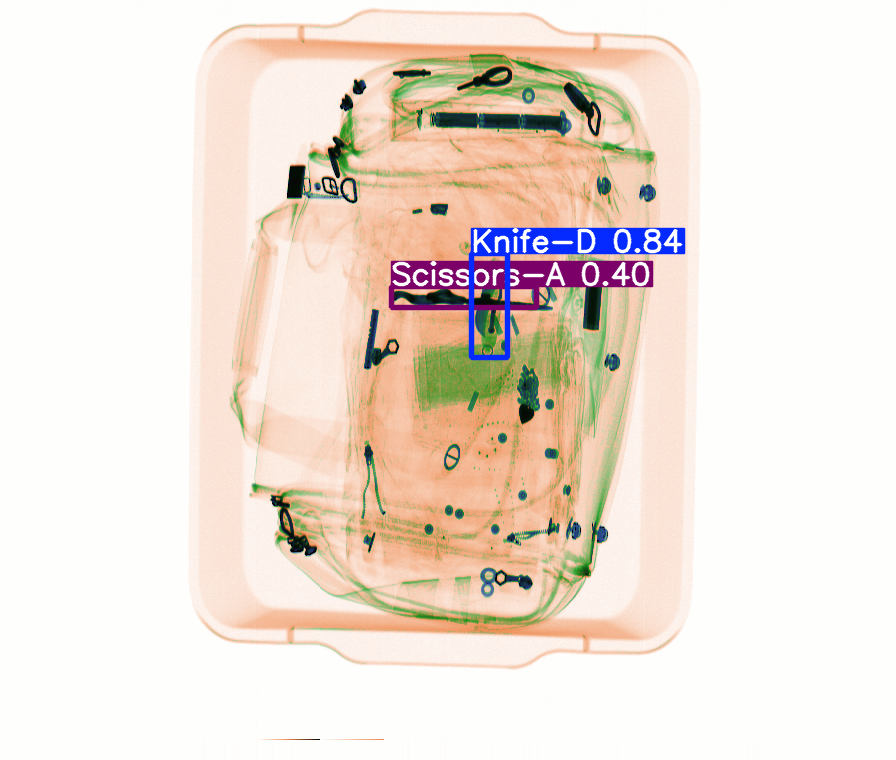

/content/yolov5/runs/detect/aihub_sample_pred/Color_E3S690_20220812_012558_M_Scissors-A_041-001_Knife-D_028-001_1.png


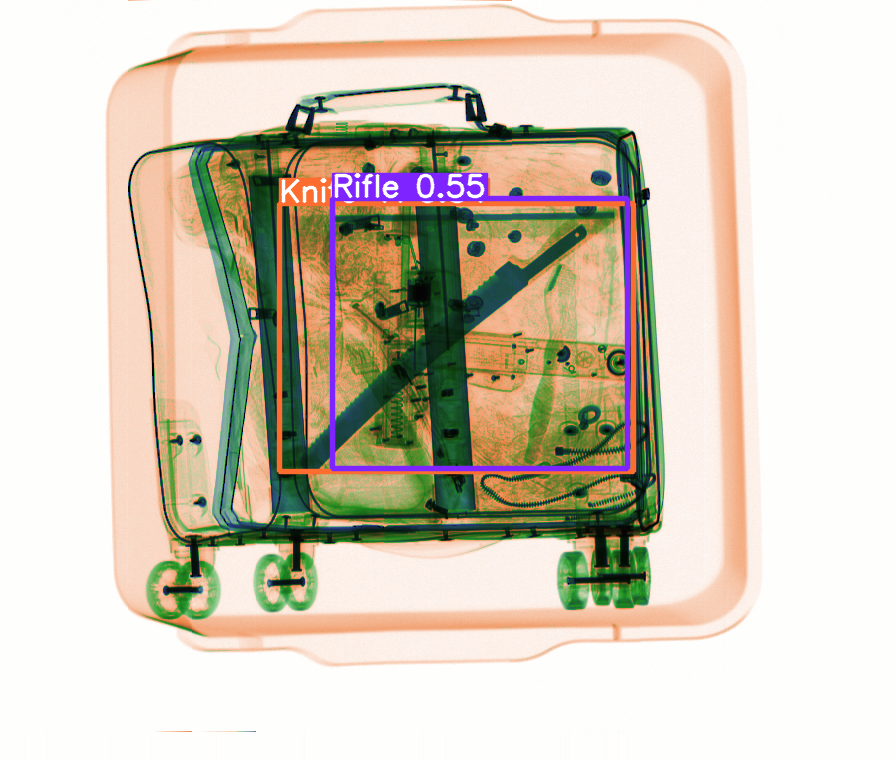

/content/yolov5/runs/detect/aihub_sample_pred/Color_E3S690_20220811_012480_M_Rifle_004-001_Knife-A_020-001_5.png


In [33]:
# runs/detect/<name>/ 폴더에 저장된 결과 이미지 중 랜덤 5장을 띄워봄
# 결과가 비어 있으면 detect가 실패했거나, 저장 폴더명이 다른 경우

import glob, random
from PIL import Image

pred_dir = "/content/yolov5/runs/detect/aihub_sample_pred"
imgs = glob.glob(pred_dir + "/*.jpg") + glob.glob(pred_dir + "/*.png")
print("pred images:", len(imgs))

for p in random.sample(imgs, k=min(5, len(imgs))):
    display(Image.open(p))
    print(p)

#### 학습/추론 결과를 Drive로 백업

In [2]:
import os, shutil

DRIVE_OUT = "/content/drive/MyDrive/Colab Notebooks/Object Detection/YOLOv5/results_run"

# Drive 백업본
src_train = os.path.join(DRIVE_OUT, "train_aihub_sample_color_gray_baseline")
src_pred  = os.path.join(DRIVE_OUT, "pred_aihub_sample_pred")

# 복원할 목적지
dst_train = "/content/yolov5/runs/train/aihub_sample_color_gray_baseline"
dst_pred  = "/content/yolov5/runs/detect/aihub_sample_pred"

# 1) 상위 폴더 생성
os.makedirs("/content/yolov5/runs/train", exist_ok=True)
os.makedirs("/content/yolov5/runs/detect", exist_ok=True)

# 2) 있으면 삭제(재실행 안전)
shutil.rmtree(dst_train, ignore_errors=True)
shutil.rmtree(dst_pred, ignore_errors=True)

# 3) 백업본이 존재하는지 체크 후 복원
assert os.path.isdir(src_train), f"백업 train 폴더가 없습니다: {src_train}"
assert os.path.isdir(src_pred),  f"백업 pred 폴더가 없습니다: {src_pred}"

shutil.copytree(src_train, dst_train)
shutil.copytree(src_pred, dst_pred)

print("restored:")
print(" -", dst_train)
print(" -", dst_pred)

restored:
 - /content/yolov5/runs/train/aihub_sample_color_gray_baseline
 - /content/yolov5/runs/detect/aihub_sample_pred
